In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
mnist = MNIST('data', train=True, transform=ToTensor(), download=True)

In [3]:
mb_size = 64
Z_dim = 100
X_dim = 28*28
Y_dim = 1
h_dim = 128


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, 
                    requires_grad=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(10, 10)
        self.l1 = nn.Linear(Z_dim+10, h_dim)
        self.l2 = nn.Linear(h_dim, X_dim)
        self.l1.weights = xavier_init(size=[Z_dim, h_dim]).t()
        self.l2.weights = xavier_init(size=[h_dim, X_dim]).t()
    
    
    def forward(self, z, c):
        c = self.embed(c)
        inp = torch.cat([z, c], 1)
        h = F.relu(self.l1(inp))
        X = F.sigmoid(self.l2(h))
        return X
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(10, 10)
        self.l1 = nn.Linear(X_dim+10, h_dim)
        self.l2 = nn.Linear(h_dim, 1)
        self.l1.weights = xavier_init(size=[X_dim, h_dim]).t()
        self.l2.weights = xavier_init(size=[h_dim, 1]).t()
    
    def forward(self, X, c):
        c = self.embed(c)
        inp = torch.cat([X, c], 1)
        h = F.relu(self.l1(inp))
        y = F.sigmoid(self.l2(h))
        return y
G = Generator()
D = Discriminator()

G.cuda()
D.cuda()

ones_label = Variable(torch.ones(mb_size, 1)).cuda()
zeros_label = Variable(torch.zeros(mb_size, 1)).cuda()

G_solver = optim.Adam(G.parameters(), lr=1e-3)
D_solver = optim.Adam(D.parameters(), lr=1e-3)

def reset_grad():
    D.zero_grad()
    G.zero_grad()

In [4]:
def show_img(I, c):
    I = I.view(28, 28).data.cpu().numpy()
    plt.imshow(I)
    plt.title('Condition: {}'.format(c))
    plt.show()

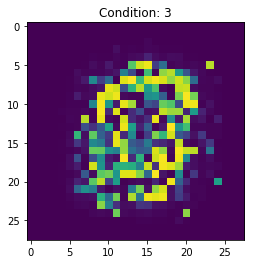

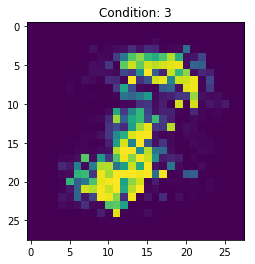

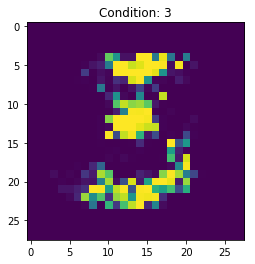

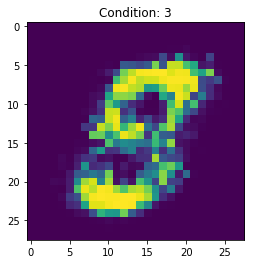

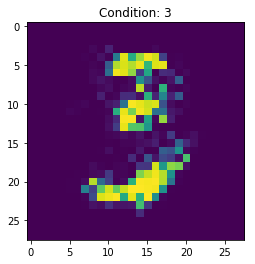

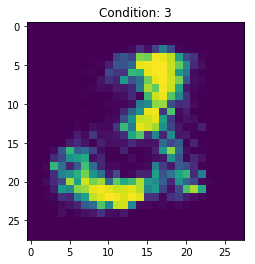

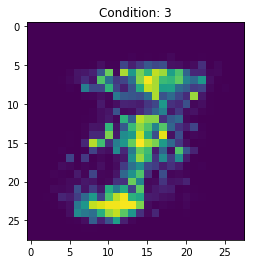

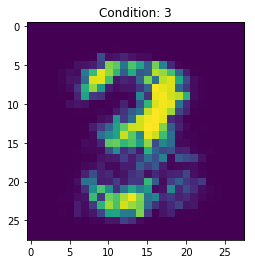

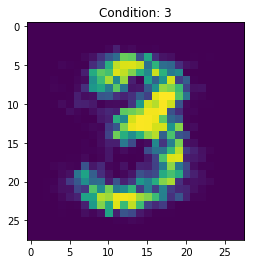

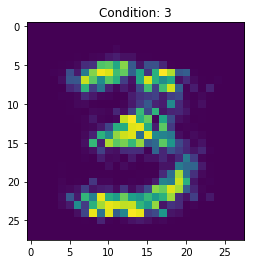

KeyboardInterrupt: 

In [5]:
d = DataLoader(mnist, mb_size, drop_last=True)

e_bar = tqdm_notebook(range(1000))
for it in e_bar:
    G_loss_avg = 0
    D_loss_avg = 0
    G_losses = []
    D_losses = []
    b_bar = tqdm_notebook(d, leave=False)
    for i, (X, c) in enumerate(b_bar):
        z = Variable(torch.randn(mb_size, Z_dim)).cuda()
        X = Variable(X).view(mb_size, X_dim).cuda()
        c = Variable(c).cuda()
        
        G_sample = G(z, c)
        D_real = D(X, c)
        D_fake = D(G_sample, c)
        D_loss_real = F.binary_cross_entropy(D_real, ones_label)
        D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label)     
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward(retain_graph=True)
        D_solver.step()
        reset_grad()
        
        z = Variable(torch.randn(mb_size, Z_dim)).cuda()
        G_sample = G(z, c)
        D_fake = D(G_sample, c)
        G_loss = F.binary_cross_entropy(D_fake, ones_label)
        G_loss.backward()
        G_solver.step()

        b_bar.set_postfix(
            D_loss=D_loss.data[0],
            G_loss=G_loss.data[0]
        )
        reset_grad()
        
        D_loss_avg += D_loss
        G_loss_avg += G_loss
        
    G_losses.append(G_loss_avg / len(d))
    D_losses.append(G_loss_avg / len(d))
    G_loss_avg = 0
    D_loss_avg = 0
    
    show_img(G_sample[0], c.data.cpu()[0])
    
    e_bar.set_postfix(
        G_loss=G_losses[-1],
        D_loss=G_losses[-1]
    )

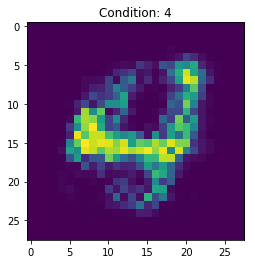

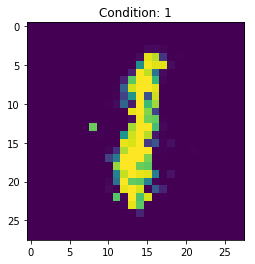

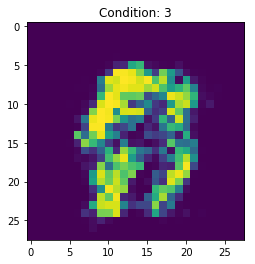

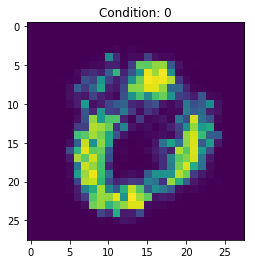

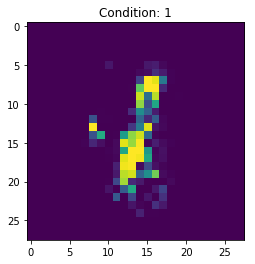

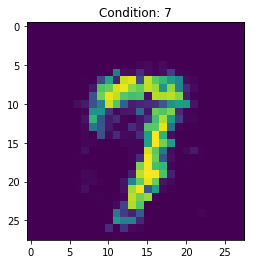

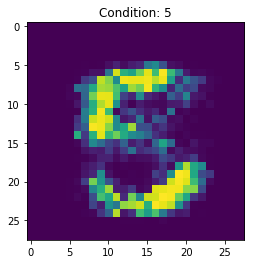

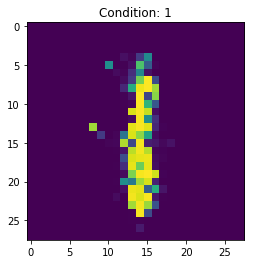

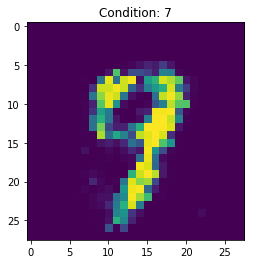

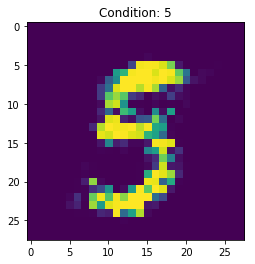

In [9]:
for _ in range(10):
    z = Variable(torch.randn(1, Z_dim)).cuda()
    c = Variable(torch.LongTensor(1).random_(0, 9)).cuda()
    G_sample = G(z, c)
    show_img(G_sample[0], c.data[0])
    
    